In [10]:
# http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf
# https://lilianweng.github.io/posts/2018-04-08-policy-gradient/

In [29]:
import torch
from IPython.display import Image
from torch import nn
import gym
gym.__version__

'0.15.4'

## summary

- Q learning => DQN
    - deep networks 去逼近 Q function （action value），回归问题
    - 输出的不是概率，而是 action value；
- policy gradient => Deep policy gradient
    - deep networks 去逼近 $\pi_\theta(a_t|s_t)$
    - 输出的是概率分布，所以最后一层要加 softmax 做概率化；

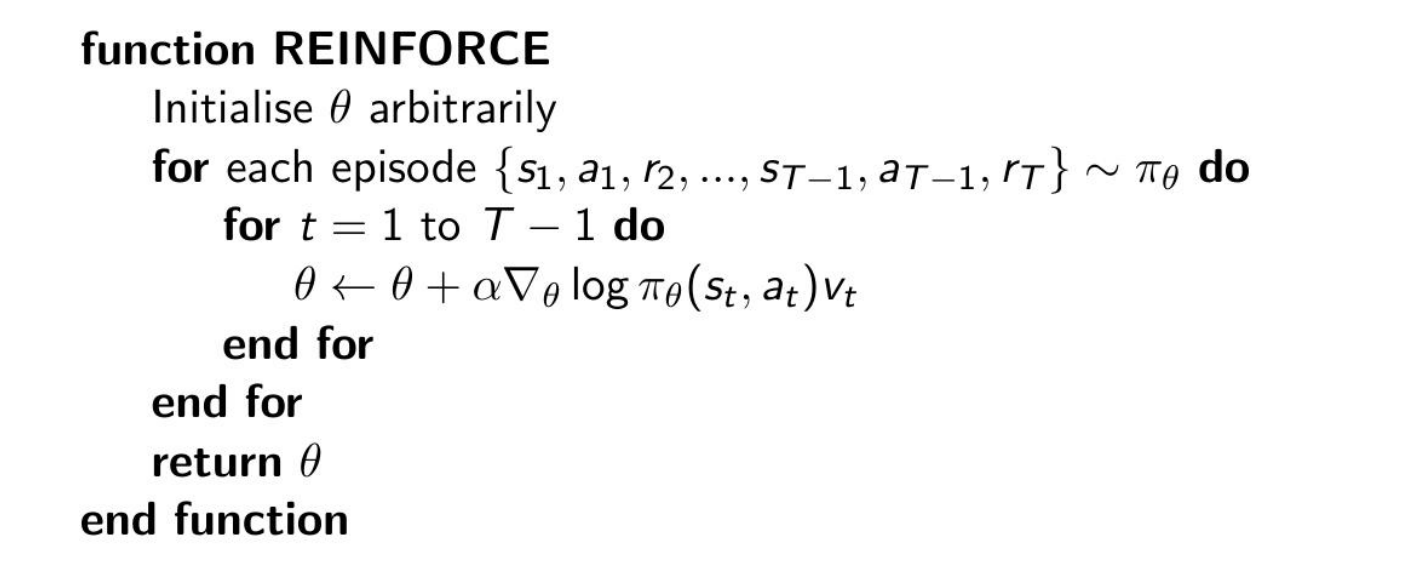

In [30]:
# http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf
Image('./imgs/reinforce.png')

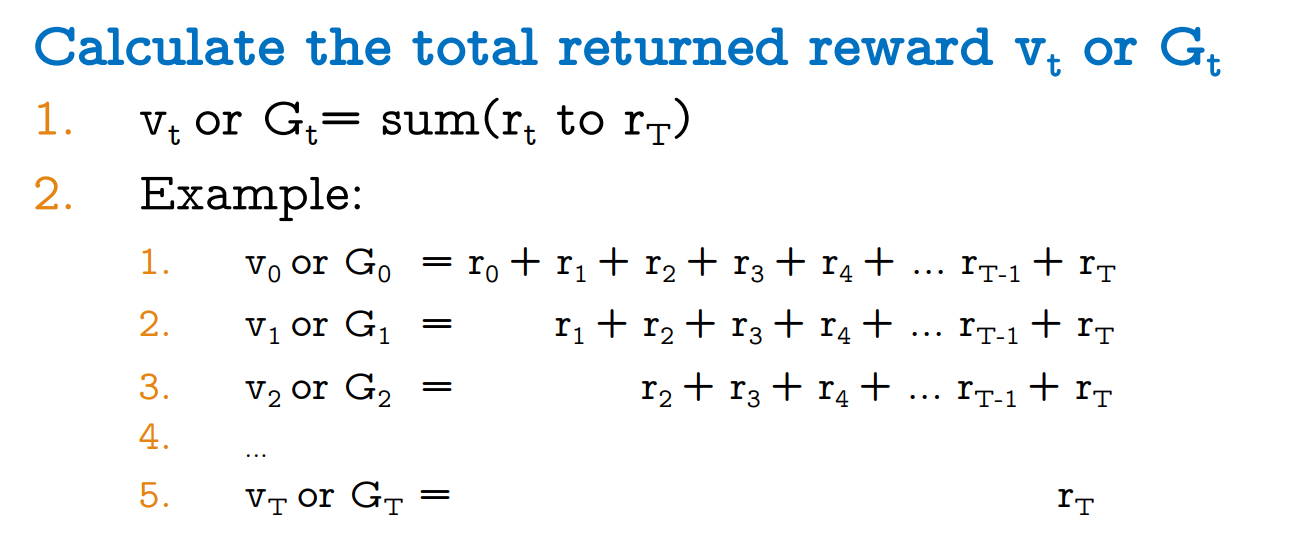

In [31]:
# http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf
# total discounted future returned reward
Image('./imgs/total_reward.png')

$$
\sum_{t}\nabla_\theta\log\pi_\theta(a_t|s_t)G_t
$$

- 注意，上述的梯度更新的公式是最大化总 reward 的期望，而神经网络是最小化一个目标；
- $v_t=G_t=\sum_{k=0}^\infty \gamma^kR_{t+k+1}$
    - discounted **future** reward
    - 当前动作的 reward 通过基于当前状态的未来 reward 折现进行估计；
- policy gradient algorithm
    - Perform a trajectory/roll-out(mcts) using the current policy (fixed $\pi_\theta(a_t|s_t)$ （神经网络来表示）)
        - trajectory：$\tau=(s_1,a_1,r_2,s_2,a_2,r_3, \cdots)$
            ```
            s = env.reset()
            a, log_p = policy(s)
            next_state, reward, done, _ = env.step(a)
            if done == True:
                break
            s = next_state
            ```
        - Store **log** probabilities (of policy, $\log\pi_\theta(a_t|s_t)$) and reward values at each step
            - 概率通过 policy network 获得；
    - Calculate **discounted cumulative future reward**($G_t$) at each step
    - Compute policy gradient ($\nabla J(\theta)$) and update policy parameter（gradient descent）
        - 反向传播，梯度更新是神经网络帮我们完成的
        - loss = $-\sum_{t}\log(\pi_{\theta}(a_t|s_t))G_t$
        - `loss.backward()`
    - Repeat 1–3

## policy network

In [32]:
import torch
from torch import nn
from torch import optim
from torch import autograd
import torch.nn.functional as F
import numpy as np

In [33]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_states, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.fc1 = nn.Linear(num_states, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        # x: state, 批次化的, x.shape == (batch, num_states), batch: 一次完整的 trajectory 经历的 steps
        # num_states of cartpole: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        # return：(batch, num_actions)， 行和为1；
        return x
    
    def choose_action(self, state):
        # given state
        # state.shape (4, ), 1d numpy ndarray
        # state, (1, 4)
        state = torch.from_numpy(state).float().unsqueeze(0)
        # probs, (1, 2)
#         probs = self.forward(autograd.Variable(state))
        probs = self.forward(state)
        # 以概率采样
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        # prob => log prob
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        # log_p < 0
        return highest_prob_action, log_prob

## discounted future reward 

In [34]:
GAMMA = 0.9

$$
G_t=\sum_{k=0}^\infty \gamma^kR_{t+k+1}
$$

In [35]:
# rewards 由一次 episode 的 trajectory 产生
def discounted_future_reward(rewards):
    discounted_rewards = []
    for t in range(len(rewards)):
        Gt = 0
        pw = 0
        for r in rewards[t:]:
            Gt += (GAMMA**pw)*r
            pw += 1
        discounted_rewards.append(Gt)
    # len(discounted_rewards) == len(rewards)
    return discounted_rewards

## update policy

In [36]:
def update_policy(policy_network, rewards, log_probs):
    # len(rewards) == len(log_probs)
    # Gt
    discounted_rewards = discounted_future_reward(rewards) 
    
    # normalize discounted rewards => stability
    # from one episode
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean())/(discounted_rewards.std() + 1e-9)
    
    policy_grads = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_grads.append(-log_prob*Gt)
    
    policy_network.optimizer.zero_grad()
    policy_grad = torch.stack(policy_grads).sum()
    policy_grad.backward()
    policy_network.optimizer.step()

## 数据从哪里来

In [37]:
env = gym.make('CartPole-v0')

In [38]:
env.observation_space.shape[0]

4

In [39]:
env.action_space.n

2

In [27]:
import matplotlib.pyplot as plt

episode: 0, total reward: 21.0, average_reward: 21.0, length: 20
episode: 100, total reward: 31.0, average_reward: 21.435643564356436, length: 30
episode: 200, total reward: 35.0, average_reward: 24.54228855721393, length: 34
episode: 300, total reward: 30.0, average_reward: 28.069767441860463, length: 29
episode: 400, total reward: 13.0, average_reward: 31.43640897755611, length: 12
episode: 500, total reward: 62.0, average_reward: 36.678642714570856, length: 61
episode: 600, total reward: 110.0, average_reward: 44.85024958402662, length: 109
episode: 700, total reward: 129.0, average_reward: 55.417974322396574, length: 128
episode: 800, total reward: 78.0, average_reward: 64.89388264669164, length: 77
episode: 900, total reward: 172.0, average_reward: 76.09655937846837, length: 171
episode: 1000, total reward: 194.0, average_reward: 84.76523476523477, length: 193
episode: 1100, total reward: 149.0, average_reward: 91.87375113533152, length: 148
episode: 1200, total reward: 200.0, ave

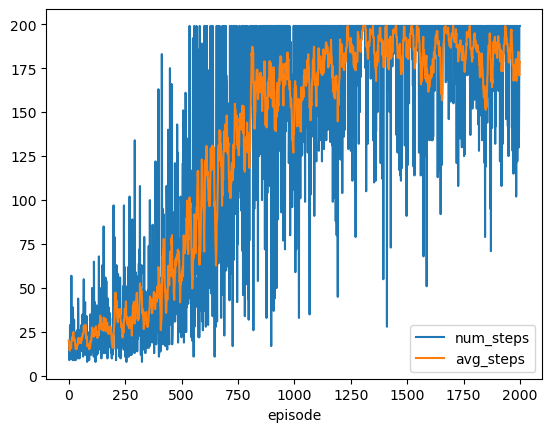

In [41]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episodes = 2000
max_steps = 500

num_steps = []
avg_num_steps = []
all_rewards = []

for episode in range(max_episodes):
    state = env.reset()
    log_probs = []
    rewards = []
    for step in range(max_steps):
        # $\pi_\theta(a_t|s_t)$
        action, log_prob = policy_net.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        
        if done:
            # 完成一次 episode/rollout，得到一次完整的 trajectory
            update_policy(policy_net, rewards, log_probs)
            num_steps.append(step)
            avg_num_steps.append(np.mean(num_steps[-10:]))
            all_rewards.append(sum(rewards))
            if episode % 100 == 0:
                print(f'episode: {episode}, total reward: {sum(rewards)}, average_reward: {np.mean(all_rewards)}, length: {step}')
            break
        state = next_state
plt.plot(num_steps)
plt.plot(avg_num_steps)
plt.legend(['num_steps', 'avg_steps'])
plt.xlabel('episode')
plt.show()